# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

You can listen to the samples on our demo page via [this](https://grad-tts.github.io/) link.

You can access Google Colab demo notebook via [this](https://colab.research.google.com/drive/1YNrXtkJQKcYDmIYJeyX8s5eXxB4zgpZI?usp=sharing) link.

**Note**: for fast synthesis prefer running inference on GPU device.

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

# For Grad-TTS
import params
from model import GradTTS
from text import text_to_sequence
from text.symbols import symbols
from utils import intersperse

# For HiFi-GAN
import sys
sys.path.append('./hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN

In [8]:
N_SPKS = 1  # 247 for Libri-TTS model and 1 for single speaker (LJSpeech)
text_cleaners = params.text_cleaners

In [9]:
generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000)
generator.load_state_dict(torch.load('./logs/kss/grad_45.pt', map_location=lambda loc, storage: loc))
_ = generator.cuda().eval()
print(f'Number of parameters: {generator.nparams}')

Number of parameters: 14813336


In [10]:
with open('./checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('./checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

Removing weight norm...


In [11]:
text = "윤석열 대통령은 29일 페이스북 모회사 메타의 마크 저커버그 최고경영자를 만나 대한민국이야말로 메타의 AI가 적용될 수 있는 훌륭한 플랫폼이 될 수 있다고 말했다."

In [12]:
x = torch.LongTensor(intersperse(text_to_sequence(text, text_cleaners), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 417]), tensor([417], device='cuda:0'))

Grad-TTS RTF: 0.10502242572623238


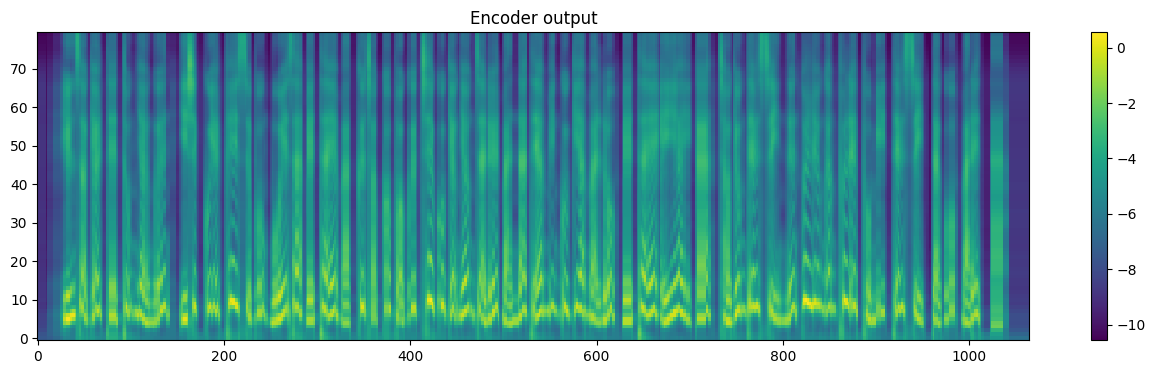

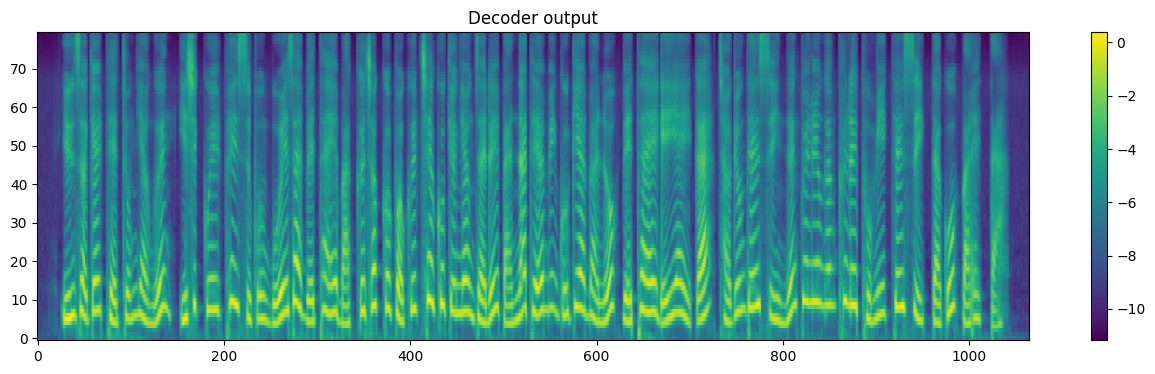

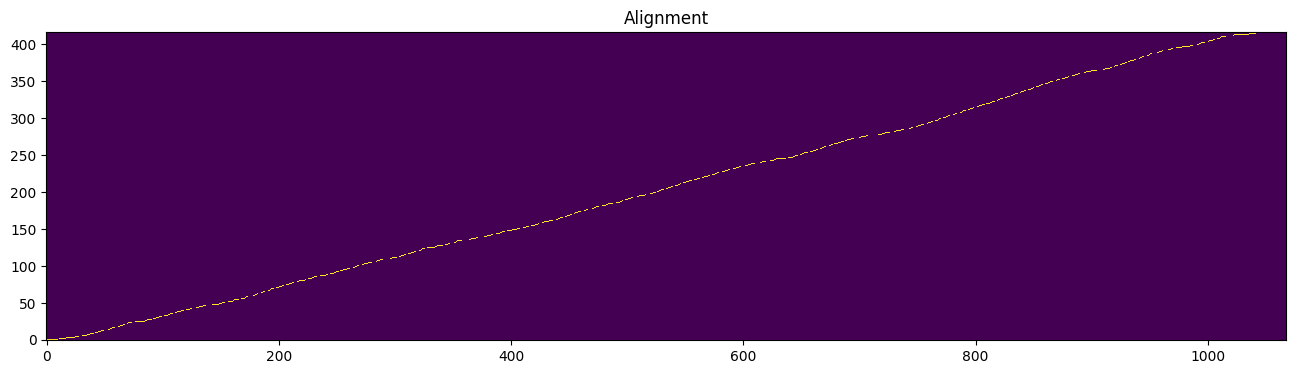

In [25]:
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=50, temperature=1.5,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]).cuda(),
                                       length_scale=0.91)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')

width = 16
height = 4

plt.subplots(figsize=(width, height))
plt.title('Encoder output')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.subplots(figsize=(width, height))
plt.title('Decoder output')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.subplots(figsize=(width, height))
plt.title('Alignment')
plt.imshow(attn.cpu().squeeze(), aspect='auto', origin='lower', interpolation='none');

In [14]:
with torch.no_grad():
    audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))